In [2]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.model_selection
from progressbar import progressbar
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pd.options.display.float_format = '{:.6f}'.format

In [4]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y, X = y.astype(np.int64), X.reshape(-1, 784).astype(np.float32)
X = X / 255
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=47)

# GAN

In [5]:
EPOCHS=500
BATCH_SIZE=128
LATENT_SIZE=2
CLASSES = 10
FEATURES = 784

generator = torch.nn.Sequential(
    torch.nn.Linear(LATENT_SIZE, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 400),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(400, FEATURES),
    torch.nn.Sigmoid(),
)

discriminator = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(FEATURES, 400),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(400, 256),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 1),
)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0003)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0003)

lossFn = torch.nn.BCEWithLogitsLoss()


In [6]:
losses_discriminator = []
losses_generator = []
for epoch in progressbar(range(EPOCHS)):
    discriminator_loss_agg = 0
    generator_loss_agg = 0
    order = np.random.permutation(train_data.shape[0])
    train_x = train_data[order]
    train_y = train_target[order]
    for i in range(0, train_x.shape[0] // BATCH_SIZE):
        batch_x = torch.from_numpy(train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

        # Train discriminator
        optimizer_discriminator.zero_grad()
        real_labels = torch.ones((BATCH_SIZE, 1))
        fake_labels = torch.zeros((BATCH_SIZE, 1))
        real_output = discriminator(batch_x)
        real_loss = lossFn(real_output, real_labels)
        fake_noise = torch.rand((BATCH_SIZE, LATENT_SIZE)) * 2 - 1
        fake_data = generator(fake_noise)
        fake_output = discriminator(fake_data)
        fake_loss = lossFn(fake_output, fake_labels)
        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        optimizer_discriminator.step()
        discriminator_loss_agg += discriminator_loss.item()
        
        # Train generator
        optimizer_generator.zero_grad()
        gen_noise = torch.randn((BATCH_SIZE, LATENT_SIZE))
        gen_data = generator(gen_noise)
        gen_labels = torch.ones((BATCH_SIZE, 1))
        gen_loss = lossFn(discriminator(gen_data), gen_labels)
        gen_loss.backward()
        optimizer_generator.step()
        generator_loss_agg += gen_loss.item()
        
    losses_discriminator.append(discriminator_loss_agg)
    losses_generator.append(generator_loss_agg)

100% (500 of 500) |######################| Elapsed Time: 1:03:05 Time:  1:03:053708


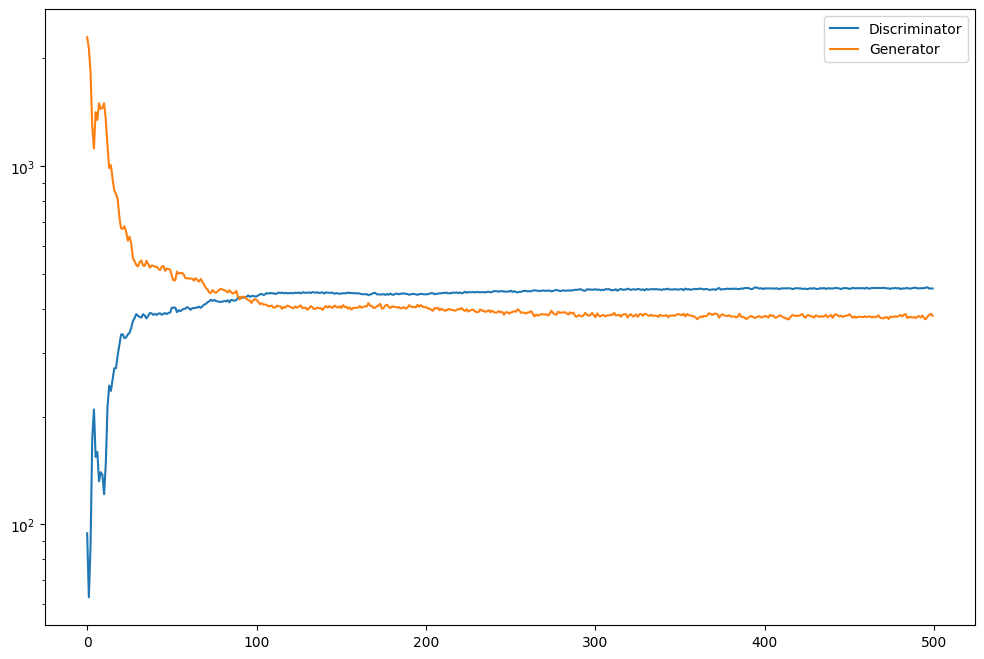

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(losses_discriminator, label='Discriminator')
plt.plot(losses_generator, label='Generator')
plt.yscale('log')
plt.legend()
plt.show()

In [8]:
torch.save(discriminator.state_dict(), 'discriminator.pth')
torch.save(generator.state_dict(), 'generator.pth')

In [9]:
discriminator.load_state_dict(torch.load('discriminator.pth'))
generator.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

In [10]:
with torch.no_grad():
    sample_data = torch.tensor([[[i / 5 - 1, j / 5 - 1] for j in range(11)] for i in range(11)]).reshape((-1, 2))
    sample_out = generator(sample_data).numpy().reshape(11, 11, 28, 28)

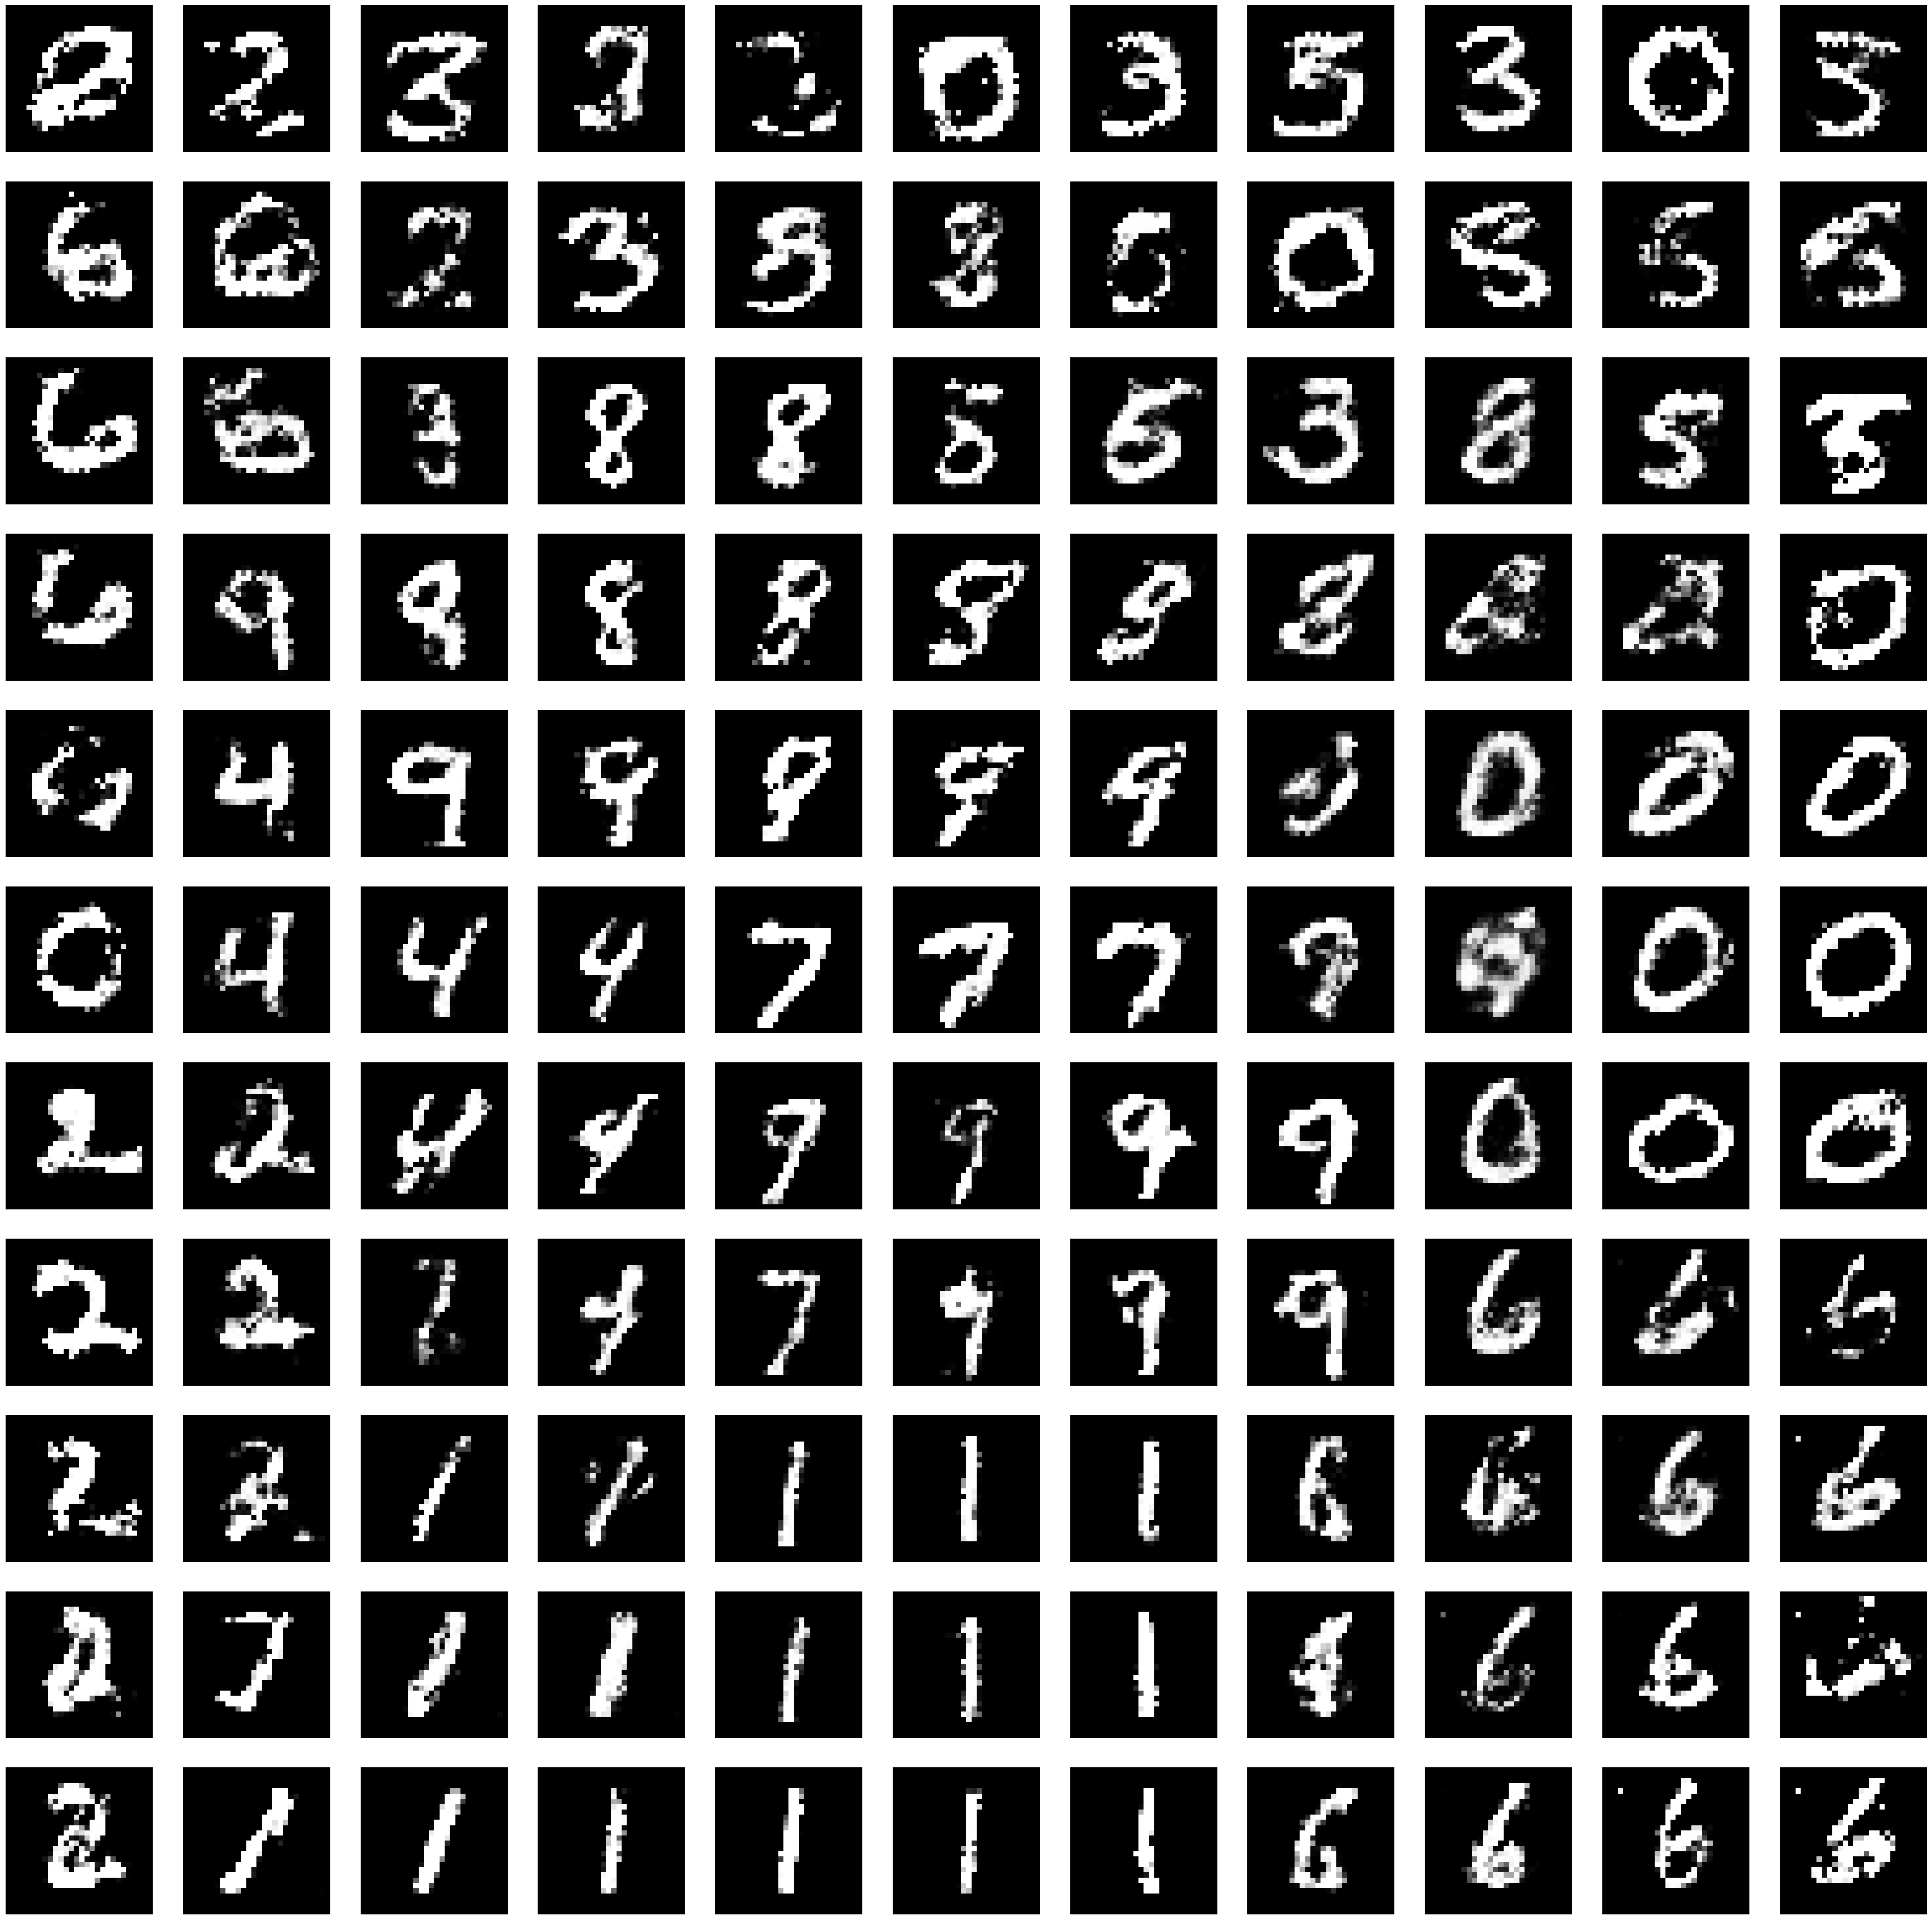

In [11]:
fig = plt.figure(figsize=(11*4, 11*4))
axes = fig.subplots(11, 11)

for i in range(11):
    for j in range(11):
        axes[i, j].imshow(sample_out[i, j], cmap='gray')
        axes[i, j].axis('off')

# GAN with classes

In [12]:
EPOCHS=500
BATCH_SIZE=128
LATENT_SIZE=1

generator = torch.nn.Sequential(
    torch.nn.Linear(LATENT_SIZE + CLASSES, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 400),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(400, FEATURES),
    torch.nn.Sigmoid(),
)

discriminator = torch.nn.Sequential(
    torch.nn.Linear(FEATURES + CLASSES, 400),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(400, 256),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 1),
)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0003)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0003)

lossFn = torch.nn.BCEWithLogitsLoss()


In [13]:
losses_discriminator = []
losses_generator = []
for epoch in progressbar(range(EPOCHS)):
    discriminator_loss_agg = 0
    generator_loss_agg = 0
    order = np.random.permutation(train_data.shape[0])
    train_x = train_data[order]
    train_y = train_target[order]
    for i in range(0, train_x.shape[0] // BATCH_SIZE):
        batch_x = torch.from_numpy(train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
        batch_y = torch.from_numpy(train_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

        # Train discriminator
        optimizer_discriminator.zero_grad()
        real_labels = torch.ones((BATCH_SIZE, 1))
        real_classes = torch.zeros((BATCH_SIZE, CLASSES))
        real_classes[torch.arange(BATCH_SIZE), batch_y] = 1
        real_with_classes = torch.cat((batch_x, real_classes), dim=1)
        real_output = discriminator(real_with_classes)
        real_loss = lossFn(real_output, real_labels)
        
        fake_labels = torch.zeros((BATCH_SIZE, 1))
        fake_noise = torch.rand((BATCH_SIZE, LATENT_SIZE)) * 2 - 1
        fake_classes = torch.zeros((BATCH_SIZE, CLASSES))
        fake_classes[torch.arange(BATCH_SIZE), torch.randint(0, CLASSES, (BATCH_SIZE,))] = 1
        fake_noise_with_classes = torch.cat((fake_noise, fake_classes), dim=1)
        fake_data = generator(fake_noise_with_classes)
        fake_data_with_classes = torch.cat((fake_data, fake_classes), dim=1)
        fake_output = discriminator(fake_data_with_classes)
        fake_loss = lossFn(fake_output, fake_labels)
        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        optimizer_discriminator.step()
        discriminator_loss_agg += discriminator_loss.item()
        
        # Train generator
        optimizer_generator.zero_grad()
        gen_noise = torch.randn((BATCH_SIZE, LATENT_SIZE))
        gen_classes = torch.zeros((BATCH_SIZE, CLASSES))
        gen_classes[torch.arange(BATCH_SIZE), torch.randint(0, CLASSES, (BATCH_SIZE,))] = 1
        gen_noise_with_classes = torch.cat((gen_noise, gen_classes), dim=1)
        gen_data = generator(gen_noise_with_classes)
        gen_labels = torch.ones((BATCH_SIZE, 1))
        gen_data_with_classes = torch.cat((gen_data, gen_classes), dim=1)
        gen_loss = lossFn(discriminator(gen_data_with_classes), gen_labels)
        gen_loss.backward()
        optimizer_generator.step()
        generator_loss_agg += gen_loss.item()
        
    losses_discriminator.append(discriminator_loss_agg)
    losses_generator.append(generator_loss_agg)

100% (500 of 500) |######################| Elapsed Time: 0:55:25 Time:  0:55:253329


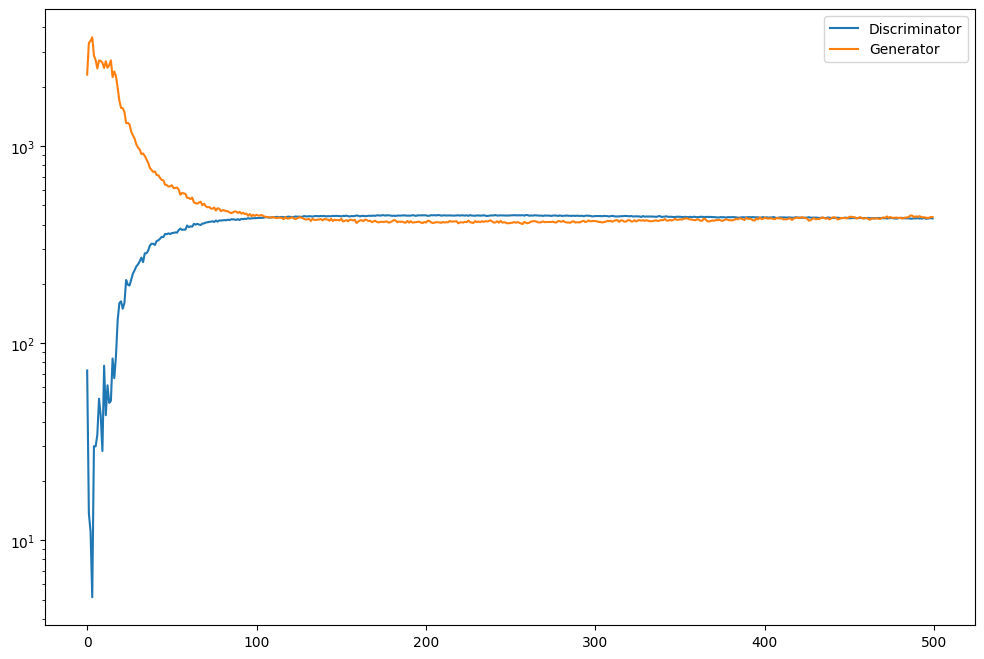

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(losses_discriminator, label='Discriminator')
plt.plot(losses_generator, label='Generator')
plt.yscale('log')
plt.legend()
plt.show()

In [15]:
torch.save(discriminator.state_dict(), 'discriminator_classes.pth')
torch.save(generator.state_dict(), 'generator_classes.pth')

In [16]:
discriminator.load_state_dict(torch.load('discriminator_classes.pth'))
generator.load_state_dict(torch.load('generator_classes.pth'))

<All keys matched successfully>

In [17]:
with torch.no_grad():
    sample_data_list = []
    for i in range(10):
        current_class = [0] * 10
        current_class[i] = 1
        for j in range(11):
            sample_data_list.append(
                torch.tensor([j / 5 -1] + current_class).reshape((-1, LATENT_SIZE + CLASSES))
            )
    sample_data = torch.cat(sample_data_list, dim=0)
    sample_out = generator(sample_data).numpy().reshape(10, 11, 28, 28)

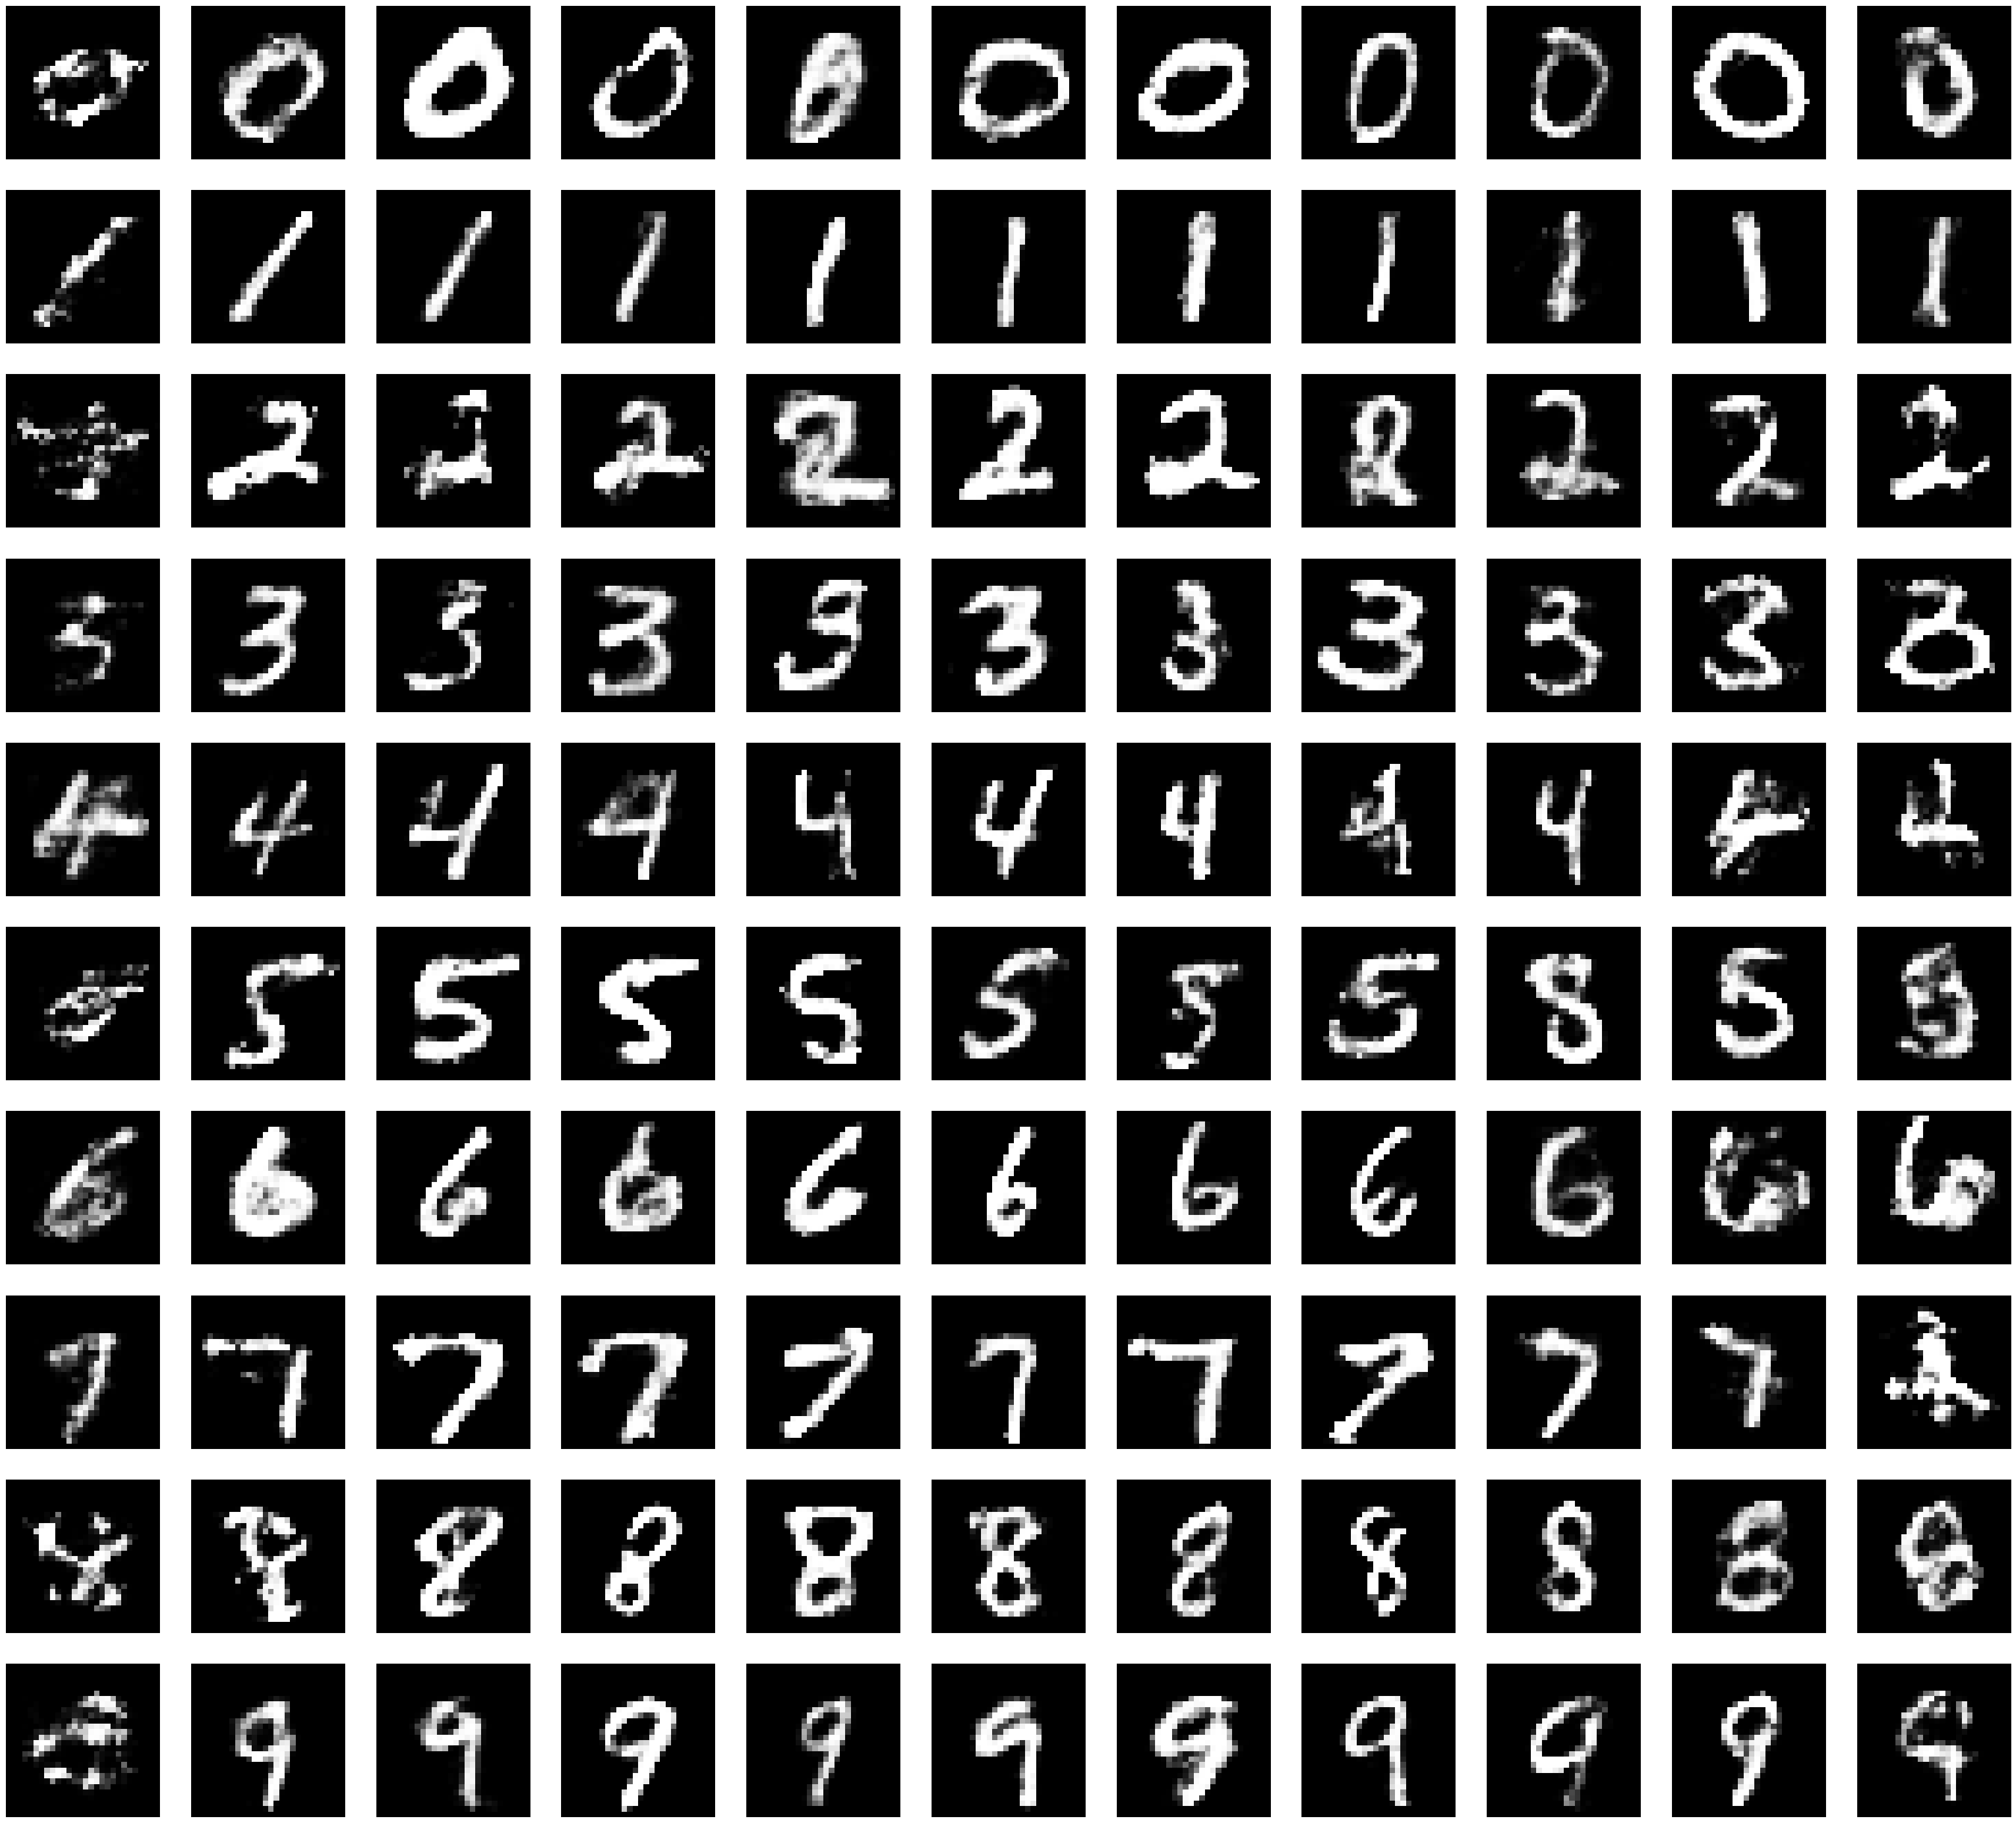

In [18]:
fig = plt.figure(figsize=(11*4, 10*4))
axes = fig.subplots(10, 11)

for i in range(10):
    for j in range(11):
        axes[i, j].imshow(sample_out[i, j], cmap='gray')
        axes[i, j].axis('off')